In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
df = pd.read_csv('cs-training.csv')
if 'Unnamed: 0' in df.columns: df = df.drop(columns=['Unnamed: 0'])
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

In [25]:
cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome']
df_woe = pd.DataFrame()
df_woe['target'] = df['SeriousDlqin2yrs']

for c in cols:
    df['bin'] = pd.qcut(df[c], q=10, duplicates='drop')
    g = df.groupby('bin')['SeriousDlqin2yrs'].agg(['count', 'sum'])
    g['good'] = g['count'] - g['sum']
    # Add epsilon to prevent log(0)
    g['woe'] = np.log((g['good'] / g['good'].sum()) / ((g['sum'] + 0.5) / g['sum'].sum()))
    d = g['woe'].to_dict()
    df_woe[c] = df['bin'].map(d)

/tmp/ipython-input-3367449927.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('bin')['SeriousDlqin2yrs'].agg(['count', 'sum'])
/tmp/ipython-input-3367449927.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('bin')['SeriousDlqin2yrs'].agg(['count', 'sum'])
/tmp/ipython-input-3367449927.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('bin')['SeriousDlqin2yrs'].agg(['co

In [26]:
X = df_woe.drop(columns=['target'])
y = df_woe['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [27]:
probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
print(f"AUC Score: {auc:.4f}")

pdo = 20
base_score = 600
base_odds = 50
factor = pdo / np.log(2)
offset = base_score - (factor * np.log(base_odds))

scores = offset + factor * np.log((1 - probs) / probs)
print(pd.DataFrame({'Probability': probs, 'Score': scores}).describe())

AUC Score: 0.7944
        Probability         Score
count  30000.000000  30000.000000
mean       0.067145    578.733893
std        0.074133     32.103267
min        0.006730    502.510035
25%        0.016631    553.649401
50%        0.031262    586.195548
75%        0.090657    604.839343
max        0.369753    631.232671


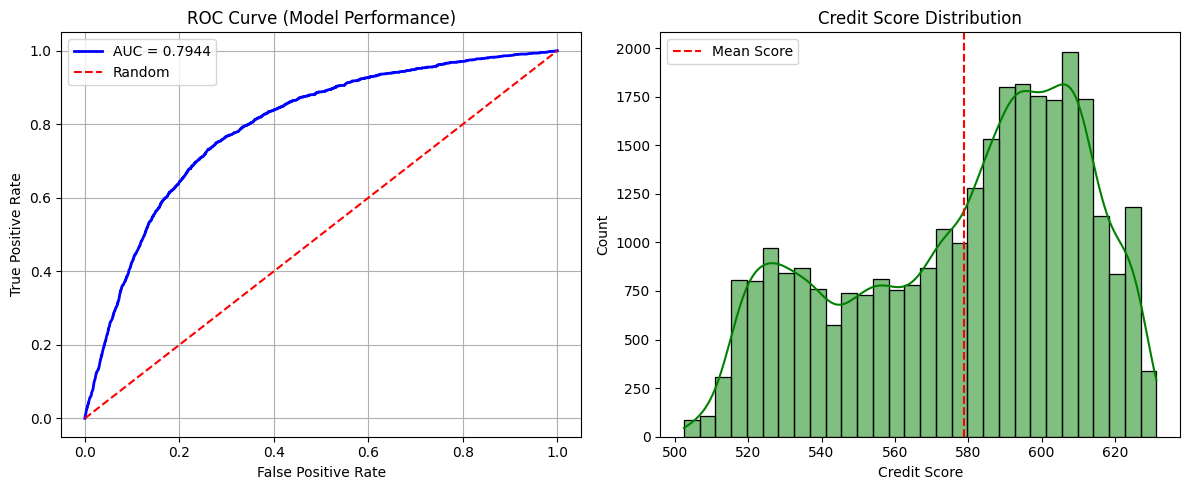

In [30]:
plt.figure(figsize=(12, 5))

# Plot 1: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.title('ROC Curve (Model Performance)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()

# Plot 2: Score Distribution
plt.subplot(1, 2, 2)
sns.histplot(results['Credit_Score'], bins=30, kde=True, color='green')
plt.axvline(results['Credit_Score'].mean(), color='red', linestyle='--', label='Mean Score')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.legend()

plt.tight_layout()
plt.show()